In [49]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Recargar el archivo
file_path = "housing.csv"
df = pd.read_csv(file_path)

target = 'median_house_value'


### Crea una regresión lineal con cross validation

In [50]:
# Dummies y NAS
df = pd.get_dummies(df)
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())


In [51]:
# Define X, y
X = df.copy()
X = X.drop(target, axis=1)

y = df[target]

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar modelo con interacciones
model = linear_model.LinearRegression().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_lineal = model.predict(X_test)
r2_score(y_pred=predicciones_lineal, y_true=y_test)

0.6395785380523733

In [52]:
## Crea una función de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    
    plt.figure(figsize=(6,4))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', marker='o', color='cadetblue')
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='red')
    plt.title('Calibración del modelo')
    plt.grid()
    plt.legend()
    plt.xlabel('Predicción')
    plt.ylabel('Real')

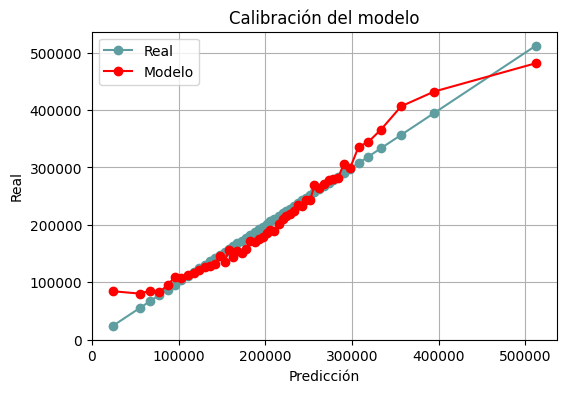

In [53]:
calibracion(predicciones_lineal, y_test, 50)

### Standard escaler

Escalar valor a media 0 y varianza 1


$Z = \frac{x - \mu}{\sigma}$


### Polinomio grado 2 y escalamiento

In [54]:

degree = 2

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly2 = model.predict(X_test)
r2_score(y_pred=predicciones_poly2, y_true=y_test)

0.6855523416341052

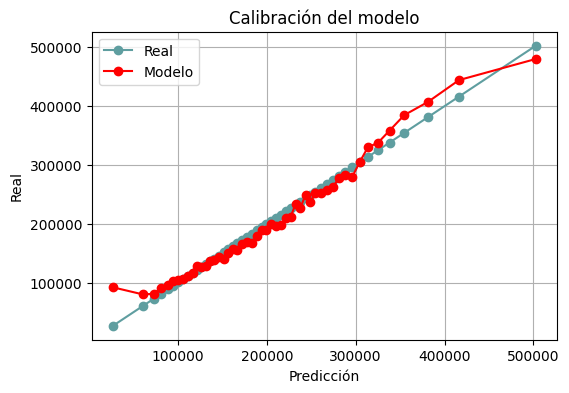

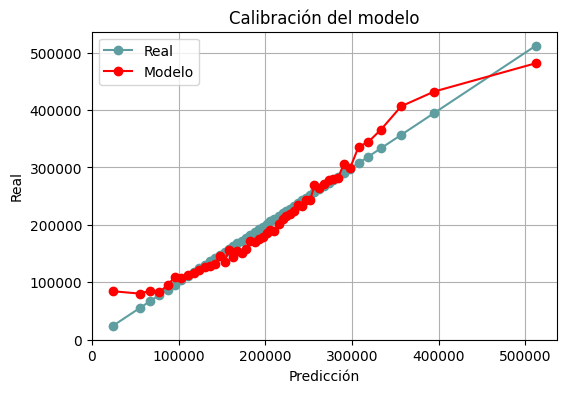

In [55]:
calibracion(predicciones_poly2, y_test, 50), 
calibracion(predicciones_lineal, y_test, 50)

#### Polinomio grado 3

In [56]:
degree = 3

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly3 = model.predict(X_test)
r2_score(y_pred=predicciones_poly3, y_true=y_test)

0.7262781624521404

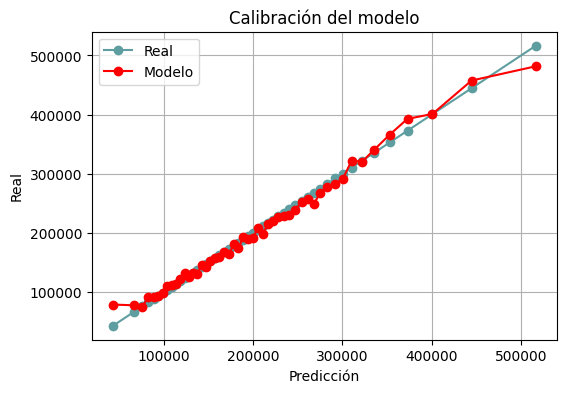

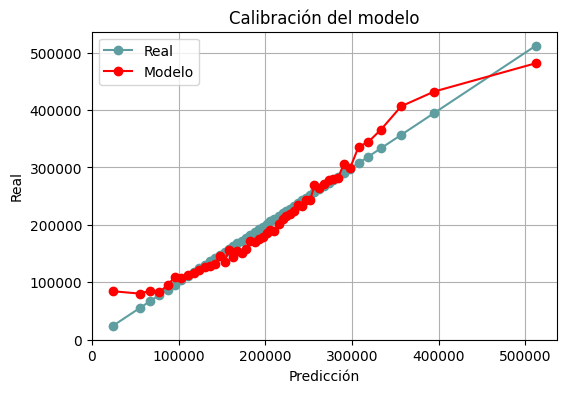

In [57]:
calibracion(predicciones_poly3, y_test, 50), 
calibracion(predicciones_lineal, y_test, 50)

### Feature engenieering 

Per room
* Population per room
* Bedrooms per room

Per household
* Population per household
* Rooms per household
* Bedrooms per household

Per population
* Income per person
* Rooms per person

Transformaciones
* Logaritmo ingreso
* Raíz de total rooms 
* Median income **2 

In [58]:
#Per room
#* Population per room
#* Bedrooms per room
df['population_per_room'] = df['population'] / df['total_rooms']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']

#Per household
#* Population per household
#* Rooms per household
#* Bedrooms per household
df['population_per_houshold'] = df['population'] / df['households']
df['total_rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_household'] = df['total_bedrooms'] / df['households']


#Per population
#* Income per person
#* Rooms per person
df['median_income_per_person'] = df['median_income'] / df['population']
df['total_rooms_per_person'] = df['total_rooms'] / df['population']

#Transformaciones
#* Logaritmo ingreso
#* Raíz de total rooms 
#* Median income **2 
df['log_income'] = np.log(df['median_income'])
df['sqrt_total_rooms'] = np.sqrt(df['total_rooms'])
df['median_income_2'] = df['median_income']**2

In [59]:
# Correlación 
df.corr()['median_house_value']

longitude                    -0.045967
latitude                     -0.144160
housing_median_age            0.105623
total_rooms                   0.134153
total_bedrooms                0.049454
population                   -0.024650
households                    0.065843
median_income                 0.688075
median_house_value            1.000000
ocean_proximity_<1H OCEAN     0.256617
ocean_proximity_INLAND       -0.484859
ocean_proximity_ISLAND        0.023416
ocean_proximity_NEAR BAY      0.160284
ocean_proximity_NEAR OCEAN    0.141862
population_per_room          -0.033557
bedrooms_per_room            -0.220049
population_per_houshold      -0.023737
total_rooms_per_household     0.151948
bedrooms_per_household       -0.044265
median_income_per_person      0.114455
total_rooms_per_person        0.209482
log_income                    0.651807
sqrt_total_rooms              0.161365
median_income_2               0.624514
Name: median_house_value, dtype: float64

In [60]:
# Define los valores numericos
numerical_features = [i for i in df.keys() if 
                      'ocean_proximity' not in i and i != 'median_house_income']

### Realiza un bivariado de las variables numericas

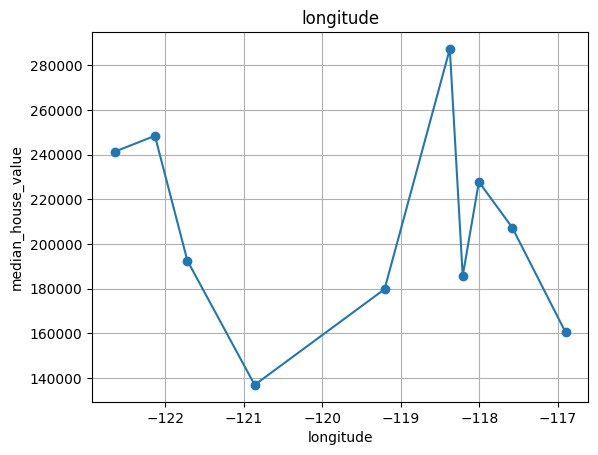

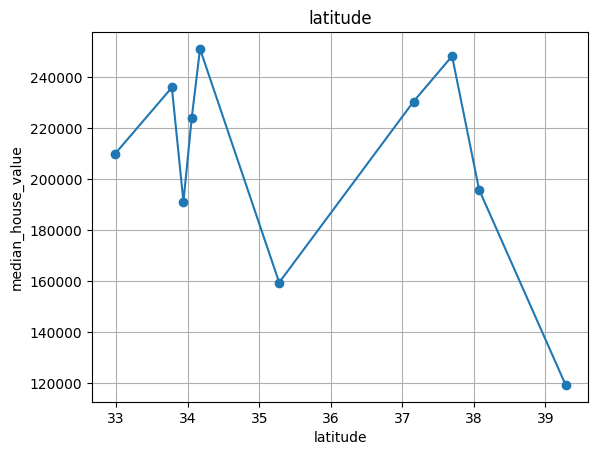

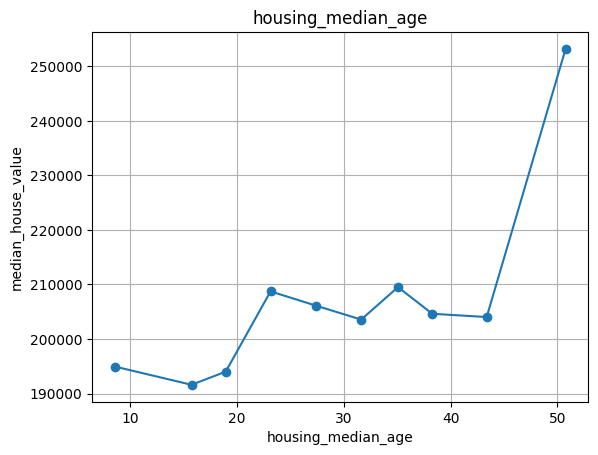

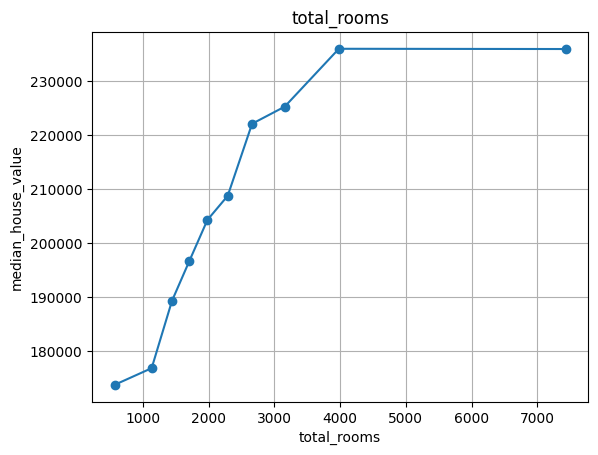

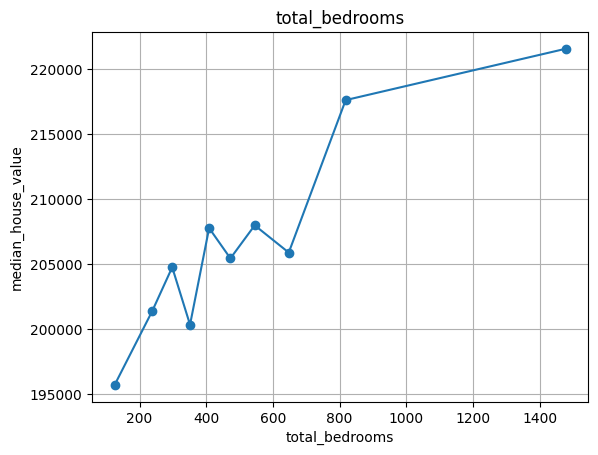

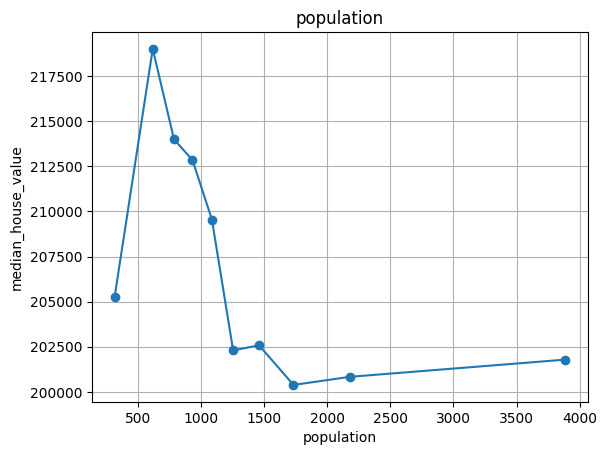

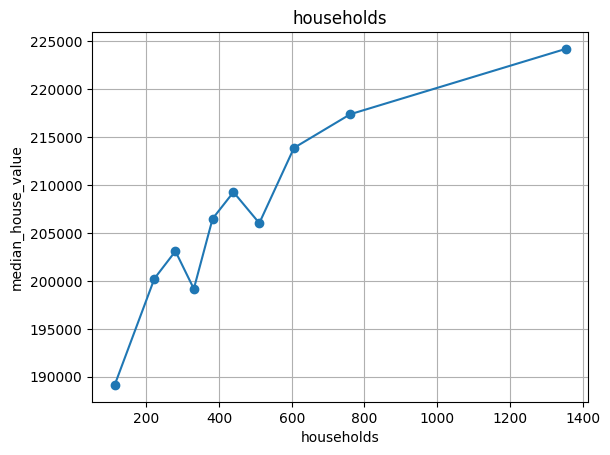

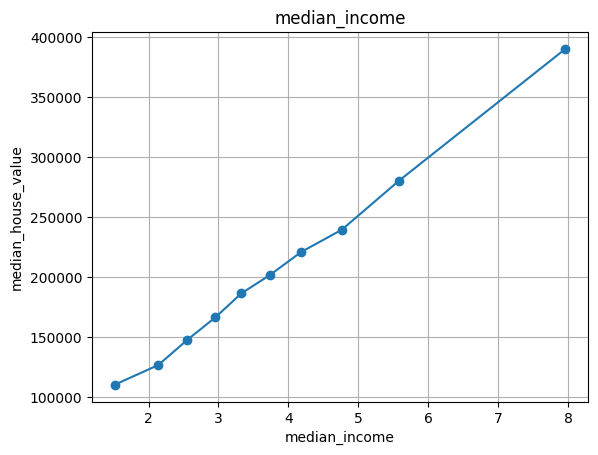

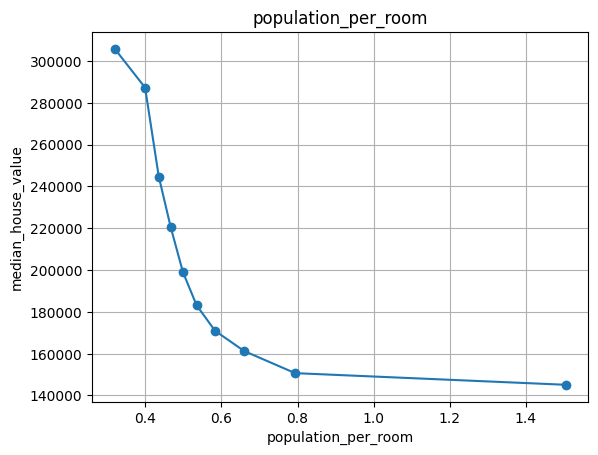

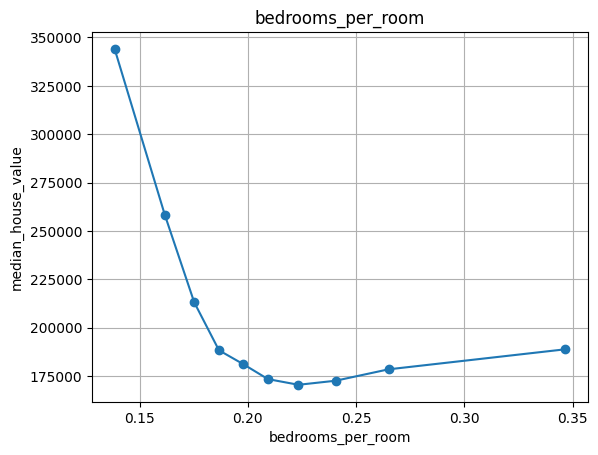

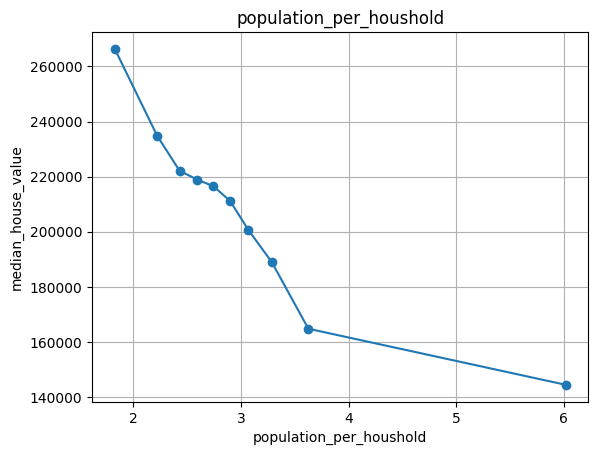

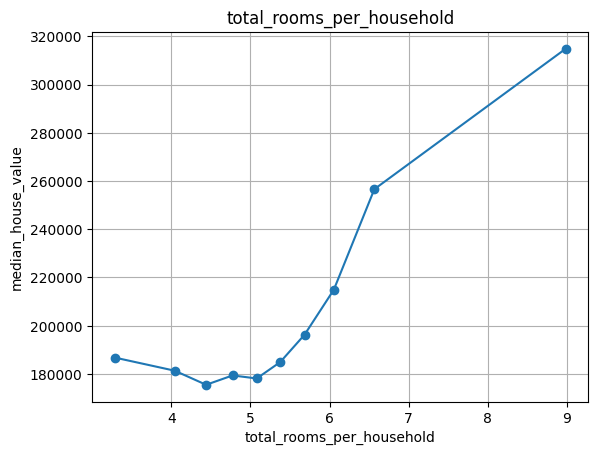

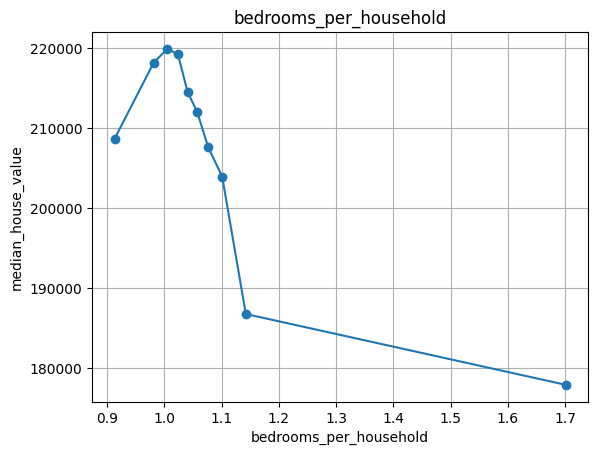

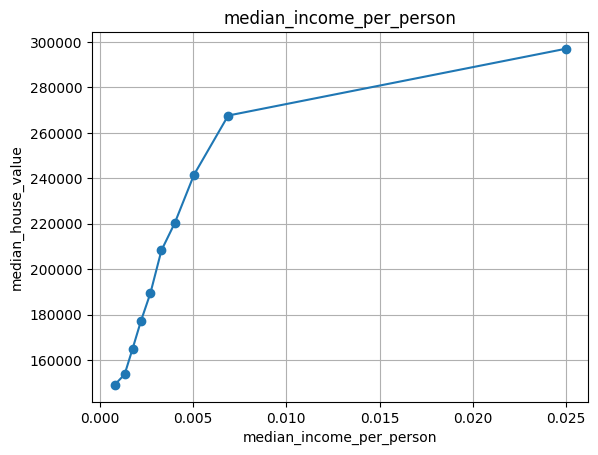

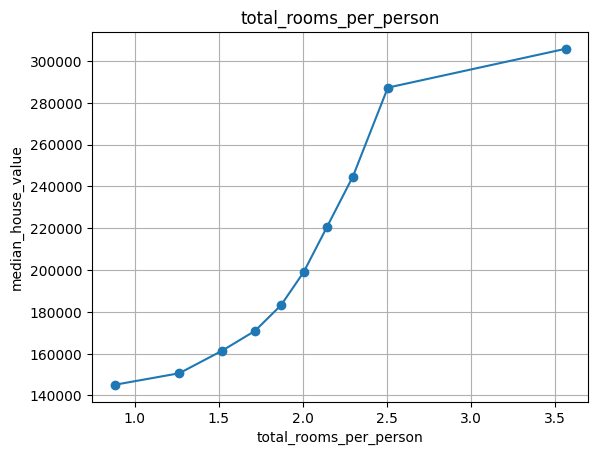

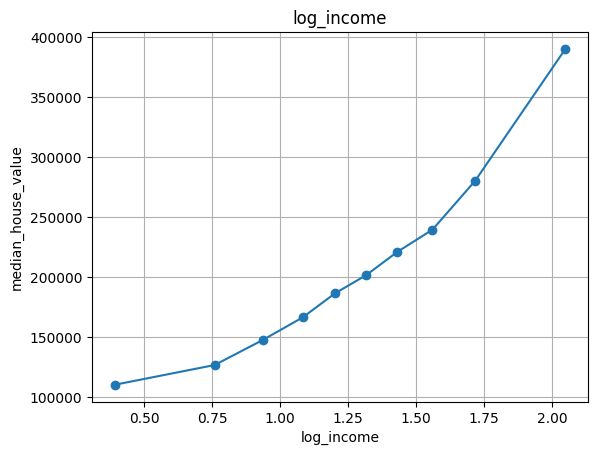

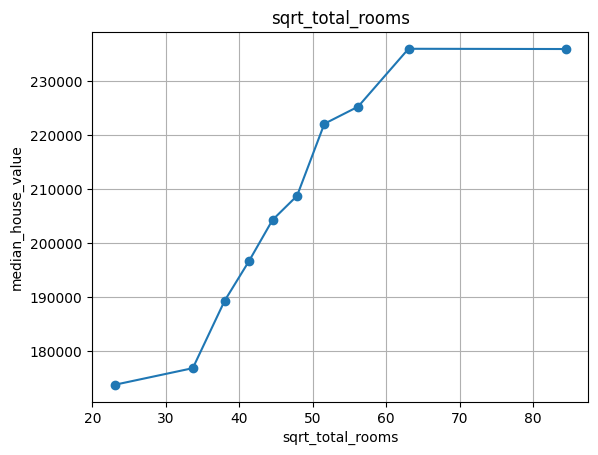

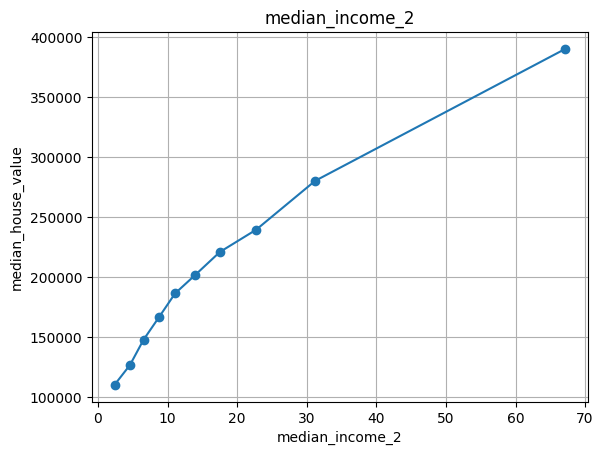

In [61]:
for i in numerical_features:
    if i != 'median_house_value':
        flag_df = df[[target, i]]
        flag_df['bins'] = pd.qcut(flag_df[i], q=10, labels=False) + 1
        grouped = flag_df.groupby('bins').mean()
        plt.figure()
        plt.plot(grouped[i], grouped[target], marker='o')
        plt.grid()
        plt.xlabel(i)
        plt.ylabel(target)
        plt.title(i)
        plt.show()


### Regresion lineal feature eng

In [62]:
## vuelve a empezar
X = df.copy()
X = X.drop(target, axis=1)

# Dummies


# Crear dataset con las variables seleccionadas


# Manejo de valores nulos (rellenar con la mediana)

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.LinearRegression().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_lineal2 = model.predict(X_test)
r2_score(y_pred=predicciones_lineal2, y_true=y_test)


0.6671666919522756

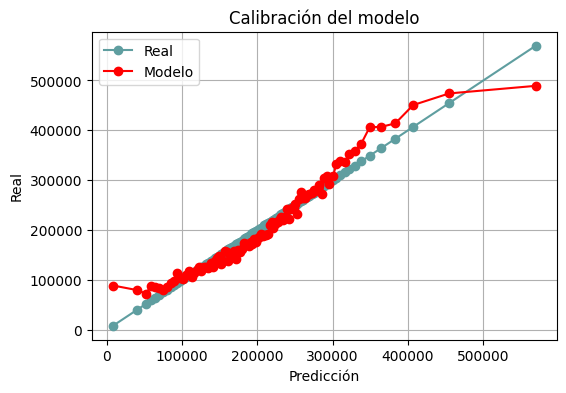

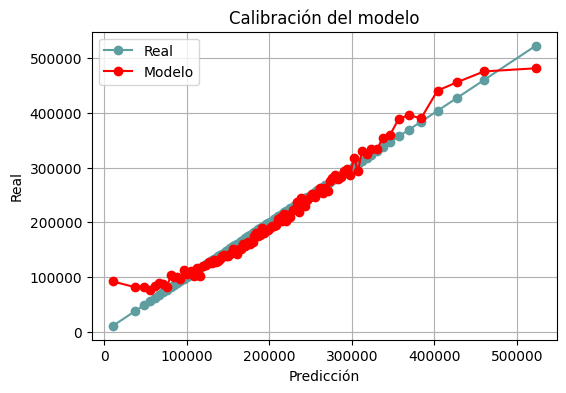

In [63]:
calibracion(predicciones_lineal, y_test, 100),
calibracion(predicciones_lineal2, y_test, 100)

### Regresion polinomial grado 2 feature eng 

In [64]:
degree = 2

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly2_fe = model.predict(X_test)
r2_score(y_pred=predicciones_poly2_fe, y_true=y_test)

-55.976540580216614

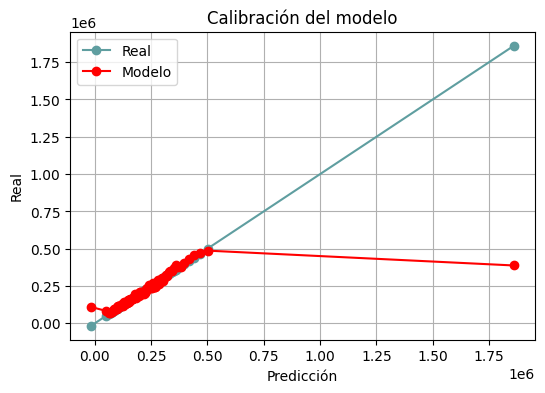

In [65]:
calibracion(predicciones_poly2_fe, y_test, bins=100)

### Regresion polinomial grado 3 feature eng 

In [66]:
degree = 3

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Ajustar el modelo de regresión Lasso o ridge 
model = linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly3_fe = model.predict(X_test)
r2_score(y_pred=predicciones_poly3_fe, y_true=y_test)

-17006.70650512541

### Transformar numericos a categoricos 

In [68]:
# Numericos ni ocean_proximity ni median_house_value
numerical_features = [i for i in df.keys() if i not in 'ocean_proximity' and i != 'median_house_value']
# X = df.copy() y drop target


In [73]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42)
# Crea funcion bins para las variables numericas 
def create_bins(X, numeric_vars, bins):
    for var in numeric_vars:
        X[f'{var}_bin']=pd.qcut(X[var], q=bins, labels=False, duplicates='drop')
    return X

X_train = create_bins(X_train, numerical_features, 25)
X_test = create_bins(X_test, numerical_features, 25)
# Aplica la foruma de bins a x_trian y x_test

# Bin features
bin_features = [i for i in X_train.keys() if 'bin' in i]
ocean_features = [i for i in X_train.keys() if 'ocean_proximity' in i]
# Final features 
final_features = bin_features + ocean_features
# Apply get dummies to both pd.get_dummies(X_train[final_features], columns=bin_features, drop_first=True)

X_train = pd.get_dummies(X_train[final_features], columns=bin_features, drop_first=True)
X_test = pd.get_dummies(X_test[final_features], columns=bin_features, drop_first=True)

# Entrenar modelo con interacciones
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

predicciones_final = model.predict(X_test)
r2_score(y_pred=predicciones_final, y_true=y_test)

0.7470948183802997

In [74]:
import lightgbm as lgb

model = lgb.LGBMRegressor().fit(X_train, y_train)
predicciones = model.predict(X_test)

r2_score(y_pred=predicciones, y_true=y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 14448, number of used features: 435
[LightGBM] [Info] Start training from score 206923.960894


0.7708327320893087

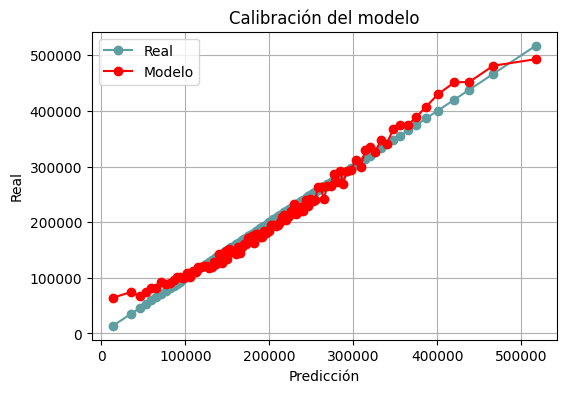

In [75]:
calibracion(predicciones_final, y_test, 100)